In [66]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import butter, lfilter
from scipy.ndimage import median_filter

In [67]:
audio_file_path = '/content/audio.mp3'
y, sr = librosa.load(audio_file_path, sr=None)

Audio(data=y, rate=sr)

In [68]:
cutoff_frequency = 500.0
order = 5
nyquist = 0.5 * sr

normal_cutoff = cutoff_frequency / nyquist
b, a = butter(order, normal_cutoff, btype='low', analog=False)
yy = lfilter(b, a, y)

window_size = 3
signal = median_filter(yy, size=window_size)


Audio(data=signal, rate=sr)

In [69]:
time_resolution = 0.125
hop_length = int(time_resolution * sr)

spectrogram = librosa.stft(y=signal, hop_length=hop_length, n_fft= 8192)
magnitude_spectrogram = np.abs(spectrogram)
print("spectrogram shape-", magnitude_spectrogram.shape)

spectrogram shape- (4097, 93)


In [70]:
frequency_of_sa = 261.63 #set according to the song scale

# semitones for each note
semitones = [0, 2, 4, 5, 7, 9, 11]

octave_frequencies = {

    'None': 0,
    'Lower_Sa': frequency_of_sa * 2**(-1),
    'Lower_Re_komal': frequency_of_sa * 2**(2/12 - 1),
    'Lower_Re': frequency_of_sa * 2**(3/12 - 1),
    'Lower_Ga': frequency_of_sa * 2**(4/12 - 1),
    'Lower_Ma': frequency_of_sa * 2**(5/12 - 1),
    'Lower_Ma_teevra': frequency_of_sa * 2**(6/12 - 1),
    'Lower_Pa': frequency_of_sa * 2**(7/12 - 1),
    'Lower_Dha_komal': frequency_of_sa * 2**(8/12 - 1),
    'Lower_Dha': frequency_of_sa * 2**(9/12 - 1),
    'Lower_Ni_komal': frequency_of_sa * 2**(10/12 - 1),
    'Lower_Ni': frequency_of_sa * 2**(11/12 - 1),

    'Sa': frequency_of_sa,
    'Re_komal': frequency_of_sa * 2**(1/12),
    'Re': frequency_of_sa * 2**(2/12),
    'Ga_komal': frequency_of_sa * 2**(3/12),
    'Ga': frequency_of_sa * 2**(4/12),
    'Ma': frequency_of_sa * 2**(5/12),
    'Ma_teevra': frequency_of_sa * 2**(6/12),
    'Pa': frequency_of_sa * 2**(7/12),
    'Dha_komal': frequency_of_sa * 2**(8/12),
    'Dha': frequency_of_sa * 2**(9/12),
    'Ni_komal': frequency_of_sa * 2**(10/12),
    'Ni': frequency_of_sa * 2**(11/12),

    'Higher_Sa': frequency_of_sa * 2**(1),
    'Higher_Re_komal': frequency_of_sa * 2**(2/12 + 1),
    'Higher_Re': frequency_of_sa * 2**(3/12 + 1),
    'Higher_Ga': frequency_of_sa * 2**(4/12 + 1),
    'Higher_Ma': frequency_of_sa * 2**(5/12 + 1),
    'Higher_Ma_teevra': frequency_of_sa * 2**(6/12 + 1),
    'Higher_Pa': frequency_of_sa * 2**(7/12 + 1),
    'Higher_Dha_komal': frequency_of_sa * 2**(8/12 + 1),
    'Higher_Dha': frequency_of_sa * 2**(9/12 + 1),
    'Higher_Ni_komal': frequency_of_sa * 2**(10/12 + 1),
    'Higher_Ni': frequency_of_sa * 2**(11/12 + 1),
}

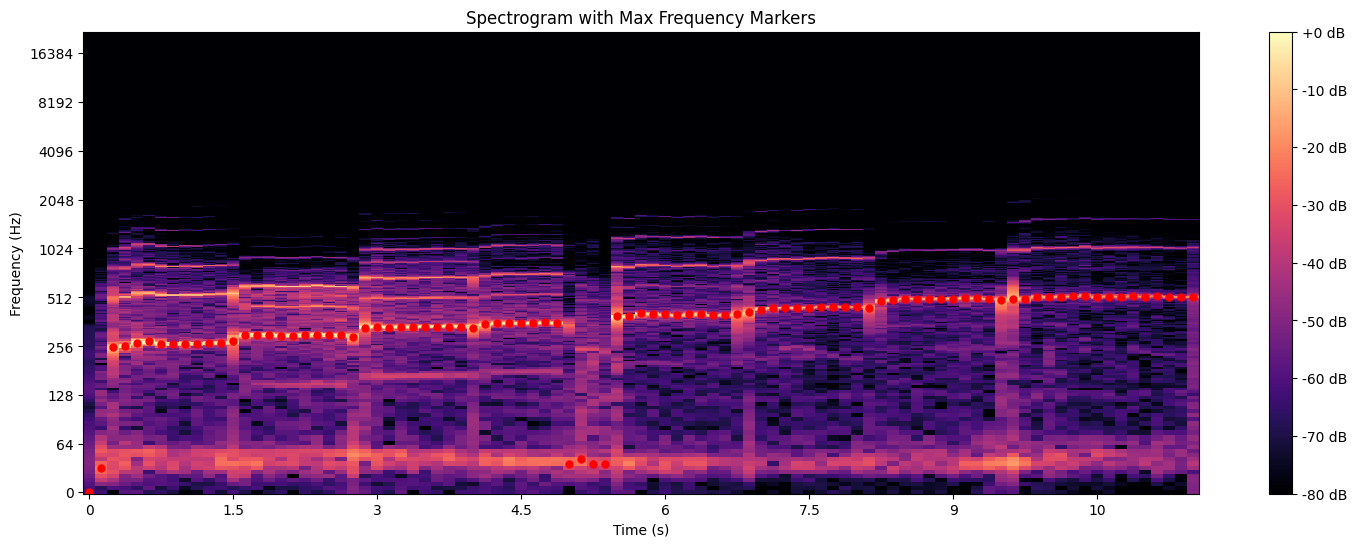

In [71]:
plt.figure(figsize=(18, 6))
librosa.display.specshow(librosa.amplitude_to_db(magnitude_spectrogram, ref=np.max), y_axis='log', x_axis='time', sr=sr, hop_length=hop_length)

# Get the shape of the magnitude spectrogram
num_fft_bins, num_time_frames = magnitude_spectrogram.shape

# Calculate the FFT frequencies with the correct length
fft_freqs = librosa.core.fft_frequencies(sr=sr, n_fft=num_fft_bins*2) # 2 for positive and negative frequencies
selected_frequencies = []
selected_times = []
selected_notes = []

# Number of consecutive bins to sum
num_bins_to_sum = 5

# Initialize an array to store the sum of consecutive bins
sum_bins = np.zeros_like(magnitude_spectrogram)

magnitude_threshold = 4

for time_index in range(magnitude_spectrogram.shape[1]):

    # Find the index of the maximum magnitude in frequency column
    max_magnitude_index = np.argmax(magnitude_spectrogram[:, time_index])

     # thresholding to skip audio lacking voice
    if magnitude_spectrogram[max_magnitude_index, time_index] < magnitude_threshold:
        frequency_at_max_magnitude = 0
    else:
        # Get the corresponding frequency for the index
        max_magnitude_index %= num_fft_bins
        frequency_at_max_magnitude = fft_freqs[max_magnitude_index]

    plt.plot(time_index * hop_length / sr, frequency_at_max_magnitude, 'ro', markersize=5) # plotting marker

    # to find nearest note dictionary
    nearest_note = min(octave_frequencies, key=lambda x: abs(octave_frequencies[x] - frequency_at_max_magnitude))

    selected_frequencies.append(frequency_at_max_magnitude)
    selected_times.append(time_index * hop_length / sr)
    selected_notes.append(nearest_note)

    #print(f'Time index- {time_index*time_resolution:.2f}--> {frequency_at_max_magnitude:.2f} Hz {nearest_note}')

plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram with Max Frequency Markers")
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

In [72]:
filtered_notes = []
filtered_times = []

count = 1
i = 1  # second element

while i < len(selected_notes):
    current_note = selected_notes[i]
    current_time = selected_times[i]

    if current_note != "None":
        if selected_notes[i - 1] == current_note:
            count += 1
        else:
            count = 1

        if count == 2:
            filtered_notes.append(current_note)
            filtered_times.append(current_time)

    i += 1

In [73]:
for time, note in zip(filtered_times, filtered_notes):
    print(f"{time:.2f}s : {note}")

0.50s : Sa
0.87s : Sa
1.75s : Re
3.00s : Ga
4.25s : Ma
5.62s : Pa
6.00s : Pa
7.12s : Dha
8.37s : Ni
10.00s : Higher_Sa
